In [1]:
import time
import datetime
import itertools
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sbs

import pickle

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler, LabelBinarizer

from sklearn.calibration import calibration_curve

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
RANDOM_SEED = 42
VERSION = 4
GOOD_CNTR_CLR = '#5FFF92'
BAD_CNTR_CLR = '#FF665F'

pd.set_option('display.max_columns', 80)
pd.options.mode.chained_assignment = None

In [3]:
def save_model(clf, clf_name, version=VERSION):
    """Сохранение модели"""
    with open('model/{}{}_mdl.pkl'.format(clf_name, version), 'wb') as file:
        pickle.dump(clf, file)
        
def save_scaler(scl, version=VERSION):
    """Сохранение нормализатора"""
    with open('model/{}_sk.pkl'.format(version), 'wb') as file:
        pickle.dump(scl, file)

def save_binarizer(bn, version=VERSION):
    """Сохранение бинаризатора"""
    with open('model/{}_bin.pkl'.format(version), 'wb') as file:
        pickle.dump(bn, file)
        
def load_model(clf_name, version=VERSION):
    """Загрузка модели"""
    with open('model/{}{}_mdl.pkl'.format(clf_name, version), 'rb') as file:
        return pickle.load(file)
    
def load_scaler(version=VERSION):
    """Загрузка нормализатора"""
    with open('model/{}_sk.pkl'.format(version), 'rb') as file:
        return pickle.load(file)

def load_binarizer(version=VERSION):
    """Загрузка бинаризатора"""
    with open('model/{}_bin.pkl'.format(version), 'rb') as file:
        return pickle.load(file)

### Базовая предобработка

In [4]:
def initinal_preprocessing():
    """Начальная предобработка"""
    
    sample = pd.read_csv(
        '../data/4/data.csv', 
        converters={'cntr_reg_num': str, 'sup_INN': str, 'sup_KPP': str, 'okpd': str, 'kbk': str}
    )
    print('Начальная выборка: {}'.format(sample.shape))
    
    # Перемешивание
    sample = sample.sample(frac=1)

    # Замена True/False на 1/0
    sample.price_higher_pmp = sample.price_higher_pmp.astype(int)
    sample.price_too_low = sample.price_too_low.astype(int)
    sample.loc[sample.cntr_result.notnull(), 'cntr_result'] = sample.loc[sample.cntr_result.notnull()].cntr_result.astype(int)

    # Перемена местами обозначений целевой переменной: "0" соответствует хорошему контракту, "1" - плохому 
    sample.loc[sample.cntr_result == 0, 'cntr_result'] = 2
    sample.loc[sample.cntr_result == 1, 'cntr_result'] = 0
    sample.loc[sample.cntr_result == 2, 'cntr_result'] = 1
    
    sample.drop(sample[sample.exec_date == -1].index, inplace=True)
    sample.drop(sample[sample.price <= 1].index, inplace=True)
    
    # Подсчет долей 
    sample['sup_good_cntr_share'] = sample.sup_good_cntr_num / sample.sup_cntr_num
    sample['sup_fed_cntr_share'] = sample.sup_fed_cntr_num / sample.sup_cntr_num
    sample['sup_sub_cntr_share'] = sample.sup_sub_cntr_num / sample.sup_cntr_num
    sample['sup_mun_cntr_share'] = sample.sup_mun_cntr_num / sample.sup_cntr_num

    sample['sup_okpd_exp'] = sample.sup_okpd_cntr_num2 / sample.sup_cntr_num

    sample['org_good_cntr_share'] = sample.org_good_cntr_num / sample.org_cntr_num
    sample['org_fed_cntr_share'] = sample.org_fed_cntr_num / sample.org_cntr_num
    sample['org_sub_cntr_share'] = sample.org_sub_cntr_num / sample.org_cntr_num
    sample['org_mun_cntr_share'] = sample.org_mun_cntr_num / sample.org_cntr_num

    sample['okpd_good_cntr_share'] = sample.okpd_good_cntr_num2 / sample.okpd_cntr_num2
    
    # Удаление ненужных столбцов
    sample.drop(['Unnamed: 0', 'okpd', 'sup_good_cntr_num', 'sup_fed_cntr_num', 'sup_sub_cntr_num', 
    'sup_mun_cntr_num', 'org_good_cntr_num', 'org_fed_cntr_num', 
    'org_sub_cntr_num', 'org_mun_cntr_num', 'sup_okpd_cntr_num2',
    'okpd_cntr_num2', 'okpd_good_cntr_num2'], inplace=True, axis=1)
    
    # Сохранение того ОКПД, которые наиболее часто встречается в рамках контракта
    for idx, cntrID in enumerate(set(sample.cntrID)):
        if (idx + 1) % 10000 == 0: print('Обработано %s контрактов' % (idx + 1))

        subsample = sample.loc[sample.cntrID==cntrID]
        if subsample.shape[0] > 1:
            most_frequent_okpd = subsample.okpd2.value_counts().index[0]
            sample.drop(sample.loc[(sample.cntrID==cntrID) & (sample.okpd2!=most_frequent_okpd)].index, inplace=True)
    
    print('1 ОКПД в рамках 1 контракта выборка: {}'.format(sample.shape[0]))
    sample.drop_duplicates(subset=['cntrID'], inplace=True)
    print('После удаления дубликатов по полю cntrID'.format(sample.shape[0]))
    
    # Размер выборок
    print('Выборка для предсказаний: {}'.format(pred_data.shape[0]))
    print('Выборка для предсказаний c sign_date >= 20170000: {}'.format(pred_data.loc[pred_data.sign_date>=20170000].shape[0]))
    print('Выборка для предсказаний c exec_date >= 20180600: {}'.format(
        pred_data.loc[pred_data.exec_date>=20180600].shape[0]))
    print('Выборка для предсказаний c sign_date >= 20170000 и exec_date >= 20180600: {}'.format(
        pred_data.loc[(pred_data.sign_date>=20170000) & (pred_data.exec_date>=20180600)].shape[0]))
    print('Обучающая выборка: {}'.format(df.shape[0]))
    
    return sample

In [5]:
def initial_preprocessing_2(sample):
    """Продолжение начальное предобработки"""
    # Добавление переменной, отражающей квартал заключения контракта
    sign_month = sample['sign_date'].apply(lambda a: pd.Series(int(str(a)[4:6])))
    sample['quarter'] = sign_month.apply(lambda a: pd.Series((a - 1) // 3 + 1))

    # Рассчет длительности контракта
    cntr_start = sample['sign_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))
    cntr_end = sample['exec_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))
    sample['cntr_length'] = (cntr_end - cntr_start)[0].apply(lambda a: pd.Series(int(str(a).split()[0])))

    sample.drop(sample[sample.cntr_length <= 1].index, inplace=True)

    # Стоимость 1 контрактного дня
    sample['one_day_price'] = sample.price / sample.cntr_length
    sample.one_day_price = sample.one_day_price.astype(int)
    
    # Данные без информационных атрибутов
    data = sample.drop([
        'cntr_reg_num', 'publish_date', 'print_form', 'kbk', 
        'purch', 'grbs_code', 'grbs_name', 'org_name', 'sup_name', 
        'sup_INN', 'sup_KPP'], axis=1)

    # Данные для построение предсказаний
    pred_data = data.loc[data.cntr_result.isnull()]
    # Обучающая выборка
    df = data.drop(data.loc[data.cntr_result.isnull()].index)
    df = df.sample(frac=1)
    df = df.dropna()
    
    # Экспорт выборок
    sample.to_csv(path_or_buf='../data/4/whole_sample.csv', encoding='utf-8', index=False)
    df.to_csv(path_or_buf='../data/4/train_test.csv', encoding='utf-8', index=False)
    pred_data.to_csv(path_or_buf='../data/4/predict.csv', encoding='utf-8', index=False)

In [6]:
def quick_reduce_okpd(df, num_of_sym=2):
    """
    Создание укороченного ОКПД и обновление связанных переменных
    """
    
    new_okpd = 'okpd{}'.format(num_of_sym)
    new_okpd_cntr_num = 'okpd_cntr_num{}'.format(num_of_sym)
    new_okpd_good_cntr_num = 'okpd_good_cntr_num{}'.format(num_of_sym)
    
    # Новая переменная
    df[new_okpd] = df['okpd'].apply(lambda a: pd.Series(a[:num_of_sym]))
    print('До группировки: {}'.format(len(set(df[new_okpd]))))
    
    # Группировка редких значений
    cnt = df[new_okpd].value_counts()
    for val, count in zip(cnt.index, cnt.values):
        if count / df.shape[0] <= 0.005:
            df.loc[df[new_okpd] == val, new_okpd] = 'NEW'    
    print('После группировки: {}'.format(len(set(df[new_okpd]))))
    
    # Пересчет переменных
    for okpd in set(df[new_okpd].values):
        subsample = sample.loc[sample.okpd.str.startswith(okpd)]
        df.loc[df.okpd.str.startswith(okpd), new_okpd_cntr_num] = np.sum(subsample.okpd_cntr_num)
        df.loc[df.okpd.str.startswith(okpd), new_okpd_good_cntr_num] = np.sum(subsample.okpd_good_cntr_num)
    
    # Удаление старых переменных
    df = df.drop(['okpd', 'sup_okpd_cntr_num', 'okpd_cntr_num', 'okpd_good_cntr_num'], axis=1)
    
    return df

def merge_okpds(df, okpd='okpd2'):
    """Мердж контрактов с несколькими ОКПД в одну запись"""
    
    lb = LabelBinarizer()
    lb.fit(df[okpd].values)
    save_binarizer(lb)
    
    ohe = pd.get_dummies(df[okpd], prefix='okpd')
    df = pd.concat([df, ohe], axis=1)
    print('После создания новых переменных: {}'.format(df.shape))
    
    df = df.drop_duplicates(subset=['cntrID', 'okpd2'])
    print('После удаление дубликатов по cntrID & okpd: {}'.format(df.shape))
    
    # Вычисление новых переменных
    vectors = []
    for idx, cntrID in enumerate(set(df.cntrID)):
        subsample = df.loc[df.cntrID==cntrID]
        okpd_transformed = lb.transform(subsample[okpd].values)
        vector = np.sum(okpd_transformed, axis=0)
        vectors.append(vector) 
    
    # Удаление дубликатов
    df = df.drop_duplicates(subset=['cntrID'])
    print('После удаление дубликатов по cntrID: {}'.format(df.shape))
    
    # Обновление значений
    df[df.columns[-35:-1]] = vectors
    return df, vectors

In [7]:
# Общая выборка
sample = pd.read_csv('../data/4/whole_sample.csv', encoding='utf-8')

# Обучающая выборка
df = pd.read_csv('../data/4/train_test.csv', encoding='utf-8')

# Выборка для построения предсказаний
pred_data = pd.read_csv('../data/4/predict.csv', encoding='utf-8')

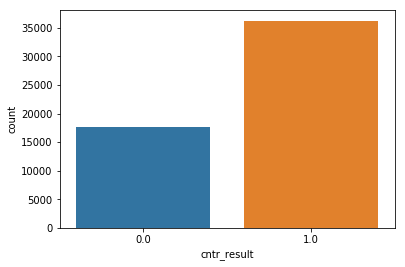

In [8]:
sbs.countplot(x='cntr_result', data=df)

In [9]:
# Перемена местами обозначений целевой переменной: "0" соответствует хорошему контракту, "1" - плохому 
sample.loc[sample.cntr_result == 0, 'cntr_result'] = 2
sample.loc[sample.cntr_result == 1, 'cntr_result'] = 0
sample.loc[sample.cntr_result == 2, 'cntr_result'] = 1

# Перемена местами обозначений целевой переменной: "0" соответствует хорошему контракту, "1" - плохому 
df.loc[df.cntr_result == 0, 'cntr_result'] = 2
df.loc[df.cntr_result == 1, 'cntr_result'] = 0
df.loc[df.cntr_result == 2, 'cntr_result'] = 1

На практике принято обозначать интересующее явление, в нашем случае плохие контракты, "1".

In [10]:
idx = int(df.shape[0] * 0.2)

# Тренировочная выборка
df_train = df.iloc[idx:,:]
# Валидационная выборка
df_valid = df.iloc[:idx,:]

### Основная предобработка

In [11]:
# Список количественных переменных с нефиксированной областью значений
num_var = [
    'sup_cntr_num', 'sup_running_cntr_num', 'sup_cntr_avg_price', 'org_cntr_num', 
    'org_cntr_avg_price', 'org_running_cntr_num','price', 'pmp',
    'cntr_num_together', 'cntr_length', 'one_day_price'
]

# Список количественных переменных с областью значений от 0 до 1
# Без учета 'sup_okpd_exp'
num_var01 = [
        'sup_good_cntr_share', 'sup_fed_cntr_share', 'sup_sub_cntr_share', 
        'sup_mun_cntr_share', 'sup_cntr_avg_penalty_share', 'sup_1s_sev', 'sup_1s_org_sev',  
        'sup_no_pnl_share', 'sup_sim_price_share', 'org_good_cntr_share', 'org_fed_cntr_share', 
        'org_sub_cntr_share', 'org_mun_cntr_share', 'org_1s_sev', 'org_1s_sup_sev', 'org_sim_price_share', 
        'okpd_good_cntr_share'
    ]

# Список категориальных переменных
cat_var = ['org_type', 'okpd2', 'purch_type', 'quarter']

# Список бинарных переменных
cat_bin_var = ['price_higher_pmp', 'price_too_low']

In [12]:
for nv in ('cntr_num_together', 'price', 'pmp'):
    num_var.remove(nv)

for nv01 in ('sup_cntr_avg_penalty_share', 'sup_1s_sev', 'sup_1s_org_sev', 
    'sup_no_pnl_share', 'org_fed_cntr_share', 'org_sub_cntr_share', 
    'org_mun_cntr_share', 'org_1s_sev', 'org_1s_sup_sev'):
    num_var01.remove(nv01)

for cv in (): cat_var.remove(cv)

cat_bin_var.clear()

In [13]:
def process_numerical(df, train=True):
    """Обработка количественных переменных"""
    if train:
        process_numerical.cache = {}
        scaler = StandardScaler()
    else:
        scaler = load_scaler()
    
    for nv in df[num_var]:
        if train:
            ulimit = np.percentile(df[nv].values, 99)
            dlimit = np.percentile(df[nv].values, 1)
            process_numerical.cache[nv] = (dlimit, ulimit)
        else:
            ulimit = process_numerical.cache[nv][1]
            dlimit = process_numerical.cache[nv][0]
            
        df.loc[df[nv] > ulimit, nv] = ulimit
        df.loc[df[nv] < dlimit, nv] = dlimit
    
    for nv in df[num_var]:
        df.loc[df[nv] < 1, nv] = 1
        df.loc[:,nv] = np.log(df[nv])
    
    if train:
        df.loc[:,num_var] = scaler.fit_transform(df[num_var])
        save_scaler(scaler)
    else:
        df.loc[:,num_var] = scaler.transform(df[num_var])
        
    return df

def process_nominal(df, train=True):
    """Обработка номинальных переменных"""
    
    if train:
        group_converters = {}
        woe_converters = {}

        for cv in cat_var:
            cnt = df[cv].value_counts()
            for val, count in zip(cnt.index, cnt.values):
                if count / df.shape[0] <= 0.005:
                    df.loc[df[cv] == val, cv] = 'NEW'

            conv = {}
            for val in set(df[cv]):
                if val != 'NEW': conv[val] = val

            group_converters[cv] = conv

        for cv in cat_var:
            cnt = df[cv].value_counts()
            conv = {}
            for val, count in zip(cnt.index, cnt.values):
                good_with_val = df.loc[(df.cntr_result == 1) & (df[cv] == val)].shape[0]
                bad_with_val = df.loc[(df.cntr_result == 0) & (df[cv] == val)].shape[0]

                p = good_with_val / df.loc[df.cntr_result == 1].shape[0]
                q = bad_with_val / df.loc[df.cntr_result == 0].shape[0]
                woe = round(np.log(p / q), 3)

                conv[val] = woe
                df.loc[df[cv]==val, cv] = round(np.log(p / q), 3)

            woe_converters[cv] = conv
       
        process_nominal.gp_convs = group_converters
        process_nominal.woe_convs = woe_converters
    else:
        for cv in cat_var:
            df.loc[:,cv] = df[cv].map(process_nominal.gp_convs[cv])
            df.loc[:,cv] = df[cv].fillna('NEW')
            df.loc[:,cv] = df[cv].map(process_nominal.woe_convs[cv])

    return df

In [14]:
df_train = process_numerical(df_train)
df_train = process_nominal(df_train)

### Обучение моделей

In [15]:
def print_classifier_info(clf_name, y_train_real, y_train_pred, y_test_real, y_test_pred, y_test_pred_proba):
    """Презентация основной информации об обученной модели"""
    
    print_str = (
        '{0}\n{1}\n{2}\nAccuracy на обучающей выборке: {3:.3f}\n'
        'Accuracy на тестовой выборке: {4:.3f}\n'
        'Log loss на тестовой выборке: {5:.3f}\n{1}\n'
    ).format(
        clf_name.upper(),
        "=" * 55 + '\n',
        classification_report(y_test_real, y_test_pred, target_names=('Хороший', 'Плохой')),
        accuracy_score(y_train_real, y_train_pred),
        accuracy_score(y_test_real, y_test_pred),
        log_loss(y_test_real[:len(y_test_pred_proba)], y_test_pred_proba)
    )
    print(print_str)

def real_and_predicted_correlation(y_test_real, y_test_pred, y_test_pred_proba):
    """
    Построение соответствия между реальными и предсказываемыми моделью 
    значениями целевой переменной
    """
    
    return pd.DataFrame({'result': y_test_real}).join(
        pd.DataFrame({'proba_pred':y_test_pred_proba[:,1]}).join(
            pd.DataFrame({'pred': y_test_pred})
        )
    )

def plot_confusion_matrix(cm, classes, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues):
    """Построение матрицы ошибок"""
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Истинные значения')
    plt.xlabel('Предсказываемые значения')
    plt.show()
    
def plot_dependence(res, title=None):
    """
    Построение распределения контрактов по предсказываемой классификатором вероятности
    относения наблюдения к плохому классу
    """
    
    counter0, counter1 = Counter(), Counter()

    for index, row in res.iterrows():
        proba = round(row['proba_pred'], 2)

        if not row['result']:
            counter0[proba] += 1
        else:
            counter1[proba] += 1
    
    corr_df0 = pd.DataFrame.from_dict(counter0, orient='index').reset_index().sort_values(['index'])
    corr_df1 = pd.DataFrame.from_dict(counter1, orient='index').reset_index().sort_values(['index'])
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)

    ax.plot(corr_df0['index'], corr_df0[0])
    ax.plot(corr_df1['index'], corr_df1[0])

    plt.legend(['Хорошие контракты', 'Плохие контракты'], loc='upper left')
    plt.xlabel('Предсказываемая вероятность плохого исхода')
    plt.ylabel('Реальное количество контрактов')
    if title:
        plt.title(title)
    plt.show()

def plot_roc_curve(y_test_real, y_test_pred_proba):
    """Построение ROC-кривой"""
    
    fpr, tpr, threshold = roc_curve(y_test_real, y_test_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--', label='Удача')
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

def learn_one_model(clf, clf_name, X, y, kfold=10, silent=False):
    """Функция для обучения одной модели"""
    
    start_time = time.time()
    
    if silent:
        print('Обучение %s' % clf_name)
    
    # Кросс-валидация 
    kfolds_generator = StratifiedKFold(n_splits=kfold, random_state=RANDOM_SEED)
    for idx, (train_index, test_index) in enumerate(kfolds_generator.split(X, y)):
        if not silent:
            print('Обучение {} разбиения'.format(idx + 1))
        
        X_train = X[train_index]
        X_test = X[test_index]
    
        y_train = y[train_index]
        y_test = y[test_index]
    
        clf.clf.fit(X_train, y_train)
    
        clf.y_train_real = np.concatenate((clf.y_train_real, y_train))
        clf.y_test_real = np.concatenate((clf.y_test_real, y_test))

        clf.y_train_pred = np.concatenate((clf.y_train_pred, clf.clf.predict(X_train)))
        clf.y_test_pred = np.concatenate((clf.y_test_pred, clf.clf.predict(X_test)))
        
        clf.y_train_pred_proba = np.concatenate((clf.y_train_pred_proba, clf.clf.predict_proba(X_train))) 
        clf.y_test_pred_proba = np.concatenate((clf.y_test_pred_proba, clf.clf.predict_proba(X_test))) 
    
    # Соответствие между реальными и предсказываемыми моделью значениями целевой переменной
    clf.res = real_and_predicted_correlation(clf.y_test_real, clf.y_test_pred, clf.y_test_pred_proba)
    
    # Время обучения модели
    clf.train_time = int(time.time() - start_time)
    
    # Сохранение модели
    save_model(clf.clf, clf_name)
    
    if not silent:
        print("Обучение заняло %s секунд\n" % (time.time() - start_time))
        # Общая информация о модели
        print_classifier_info(
            clf_name, clf.y_train_real, clf.y_train_pred, 
            clf.y_test_real, clf.y_test_pred, clf.y_test_pred_proba
        )
        
        # Матрица ошибок
        plot_confusion_matrix(
            confusion_matrix(clf.y_test_real, clf.y_test_pred), 
            classes=clf.clf.classes_, 
            title='Матрица ошибок'
        )
        
        # Распределение конрактов
        plot_dependence(clf.res)
        
        # ROC-кривая
        plot_roc_curve(clf.y_test_real, clf.y_test_pred_proba[:,1])

def assess_probability_power(clfs, figsize=(20, 10)):
    """Визуализации вероятностной предсказательной силы классификатора"""
    
    fig = plt.figure(figsize=figsize)
    clf_num = len(clfs)
    res = {}
    
    for idx, clf in enumerate(clfs):
        ax1 = fig.add_subplot(2, clf_num, idx + 1)    
        ax1.plot([0, 1], [0, 1], "k:", label="Идеальный классификатор")
        ax2 = fig.add_subplot(2, clf_num, idx + 1 + clf_num)

        fraction_of_positives, mean_predicted_value = calibration_curve(
            clf.y_test_real, clf.y_test_pred_proba[:,1], n_bins=10)

        ax1.plot(
            mean_predicted_value, fraction_of_positives, "s-", 
            label='%s (log loss: %1.3f)' % (clf.short_name, log_loss(clf.y_test_real, clf.y_test_pred_proba))
        )
        ax2.hist(clf.y_test_pred_proba[:,1], range=(0, 1), bins=10, histtype="step", lw=2)

        ax1.set_ylabel('Доля наблюдений плохого класса')
        ax1.set_xlabel('Средняя предсказываемая вероятность')
        ax1.set_ylim([-0.05, 1.05])
        ax1.legend(loc='lower right')
        ax1.set_title(clf.short_name)

        ax2.set_ylabel('Количество наблюдений')
        ax2.set_xlabel('Средняя предсказываемая вероятность')

In [16]:
var = ['cntrID']
var.extend(num_var)
var.extend(num_var01)
var.extend(cat_var)

In [17]:
df_train = df_train[var + ['cntr_result']]

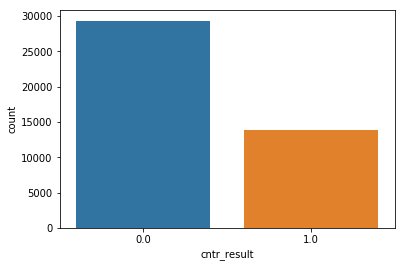

In [18]:
sbs.countplot(x='cntr_result', data=df_train)

In [19]:
# Балансировка выборки
bad_cntr = df_train.loc[df_train.cntr_result == 1]
good_cntr = df_train.loc[df_train.cntr_result == 0].sample(bad_cntr.shape[0], random_state=RANDOM_SEED)
data = bad_cntr.append(good_cntr)

In [20]:
print(data.shape)
data.head()

(27674, 22)


,cntrID,sup_cntr_num,sup_running_cntr_num,sup_cntr_avg_price,org_cntr_num,org_cntr_avg_price,org_running_cntr_num,cntr_length,one_day_price,sup_good_cntr_share,sup_fed_cntr_share,sup_sub_cntr_share,sup_mun_cntr_share,sup_sim_price_share,org_good_cntr_share,org_sim_price_share,okpd_good_cntr_share,org_type,okpd2,purch_type,quarter,cntr_result
10795,32462781,-0.571102,-0.693879,1.135348,-1.202811,-1.217703,-0.772390,-0.485287,-0.166489,0.333333,0.333333,0.666667,0.0,0.333,0.982143,0.152,1.083690,0.242,1.778,-0.088,0.488,1.0
10798,30774295,-1.205234,-0.693879,-0.387771,-0.119430,0.975138,-0.789023,1.014680,-0.785989,0.000000,1.000000,0.000000,0.0,1.000,0.956410,0.077,1.203434,0.242,0.168,0.265,0.488,1.0
10799,38343375,-1.205234,-0.693879,0.034104,1.394225,-0.226021,0.885676,-0.485287,0.428018,0.000000,1.000000,0.000000,0.0,1.000,0.866756,0.103,1.072857,0.02,1.43,-0.088,-0.029,1.0
10800,31825893,0.063030,-0.234072,-1.123291,0.575280,-0.116515,0.220483,0.343944,-1.610147,0.555556,0.888889,0.111111,0.0,0.111,0.952765,0.025,1.036036,0.02,-0.562,-0.088,0.488,1.0
10803,34096264,0.229083,0.373759,0.096065,-0.065479,-0.383245,0.311674,1.085148,-1.592570,0.833333,0.750000,0.250000,0.0,0.250,0.742169,0.065,1.203434,0.242,0.168,-0.088,0.488,1.0


In [21]:
X = data.drop(['cntr_result', 'cntrID'], axis=1).values
y = data.cntr_result.values

In [22]:
class Classifier():
    """Класс для удобства обучения моделей"""
    
    def __init__(self, clf, name, short_name):
        self.clf = clf
        self.name = name
        self.short_name = short_name
    
    y_train_real = np.array([])
    y_test_real = np.array([])
    
    y_train_pred = np.array([])
    y_test_pred = np.array([])
    
    y_train_pred_proba = np.zeros((0, 2))
    y_test_pred_proba = np.zeros((0, 2))

In [23]:
# Классификаторы
classifiers = [
    Classifier(LogisticRegression(random_state=RANDOM_SEED), 'LogisticRegression', 'LogReg'),
    Classifier(RandomForestClassifier(random_state=RANDOM_SEED), 'RandomForestClassifier', 'RandForest'),
    Classifier(XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1), 'XGBoostClassifier', 'XGBoost'),
]

In [24]:
%%time
 # Обучение первичных моделей на кросс-валидации 
scores = []
metrics = ['roc_auc', 'accuracy', 'neg_log_loss']
for clf in classifiers:
    scores.append(
        cross_validate(
            clf.clf, X, y, scoring=metrics, 
            cv=10, return_train_score=True
        )
    )

Wall time: 21.1 s


In [25]:
# Вывод результатов 
res = {}
metric_keys = ['train_{}'.format(metric) for metric in metrics]
metric_keys.extend(['test_{}'.format(metric) for metric in metrics])

for clf, score in zip(classifiers, scores):
    res[clf.short_name] = [np.mean(score[metric]) for metric in metric_keys]
    
res = pd.DataFrame(res, index=metric_keys)
res = res.round(decimals=3)
res = res[['LogReg', 'RandForest', 'XGBoost']]
res

,LogReg,RandForest,XGBoost
train_roc_auc,0.967,1.000,0.981
train_accuracy,0.899,0.996,0.926
train_neg_log_loss,-0.249,-0.052,-0.167
test_roc_auc,0.967,0.971,0.979
test_accuracy,0.899,0.915,0.922
test_neg_log_loss,-0.250,-0.395,-0.175


In [26]:
%%time
# Обучение моделей с помощью самописной функции
for clf in classifiers:
    learn_one_model(clf, clf.short_name, X, y, silent=True)

Обучение LogReg
Обучение RandForest
Обучение XGBoost
Wall time: 22.4 s


In [27]:
# Анализ важности признаков для алгоритма
log_reg_fi = sorted(
    list(zip(data.columns[1:-1], classifiers[0].clf.coef_[0])),
    key=lambda a: np.abs(a[1]), 
    reverse=True
)

rand_forest_fi = sorted(
    list(zip(data.columns[1:-1], classifiers[1].clf.feature_importances_)),
    key=lambda a: a[1], 
    reverse=True
)

xgboost_fi = sorted(
    list(zip(data.columns[1:-1], classifiers[2].clf.feature_importances_)),
    key=lambda a: a[1],
    reverse=True
)

res = pd.DataFrame(
    {
        'LogReg': ['{}: {:.2f}'.format(elem[0], elem[1]) for elem in log_reg_fi],
        'RandForest': ['{}: {:.2f}'.format(elem[0], elem[1]) for elem in rand_forest_fi],
        'XGBoost': ['{}: {:.2f}'.format(elem[0], elem[1]) for elem in xgboost_fi]
    })

In [28]:
# 5 самых важных признаков
res.head()

,LogReg,RandForest,XGBoost
0,sup_good_cntr_share: -15.40,sup_good_cntr_share: 0.57,sup_good_cntr_share: 0.32
1,sup_mun_cntr_share: 3.58,okpd2: 0.07,org_good_cntr_share: 0.13
2,sup_fed_cntr_share: 3.53,okpd_good_cntr_share: 0.04,okpd2: 0.09
3,sup_sub_cntr_share: 3.18,org_good_cntr_share: 0.04,one_day_price: 0.07
4,sup_sim_price_share: -2.47,cntr_length: 0.03,sup_cntr_num: 0.06


In [29]:
# 5 самых неважных признаков
res.iloc[-5:,:]

,LogReg,RandForest,XGBoost
15,sup_running_cntr_num: -0.19,sup_sub_cntr_share: 0.02,org_sim_price_share: 0.01
16,org_cntr_num: 0.09,sup_mun_cntr_share: 0.01,sup_mun_cntr_share: 0.01
17,purch_type: 0.06,quarter: 0.01,quarter: 0.01
18,cntr_length: 0.01,org_type: 0.01,sup_sim_price_share: 0.00
19,org_running_cntr_num: -0.01,purch_type: 0.00,purch_type: 0.00


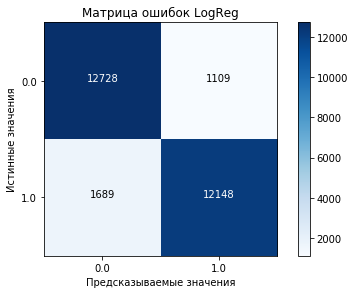

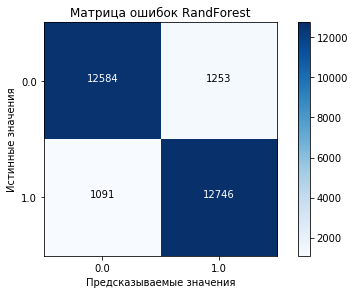

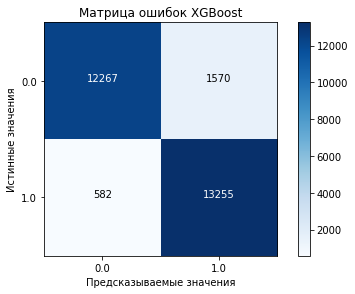

In [30]:
for clf in classifiers:
    plot_confusion_matrix(
        confusion_matrix(clf.y_test_real, clf.y_test_pred),
        clf.clf.classes_,
        title='Матрица ошибок %s' % clf.short_name
    )

In [31]:
# Основные метрики
for clf in classifiers:
    print('{}\n{}\n'.format(
        clf.short_name,
        classification_report(clf.y_test_real, clf.y_test_pred)))

LogReg
             precision    recall  f1-score   support

        0.0       0.88      0.92      0.90     13837
        1.0       0.92      0.88      0.90     13837

avg / total       0.90      0.90      0.90     27674


RandForest
             precision    recall  f1-score   support

        0.0       0.92      0.91      0.91     13837
        1.0       0.91      0.92      0.92     13837

avg / total       0.92      0.92      0.92     27674


XGBoost
             precision    recall  f1-score   support

        0.0       0.95      0.89      0.92     13837
        1.0       0.89      0.96      0.92     13837

avg / total       0.92      0.92      0.92     27674




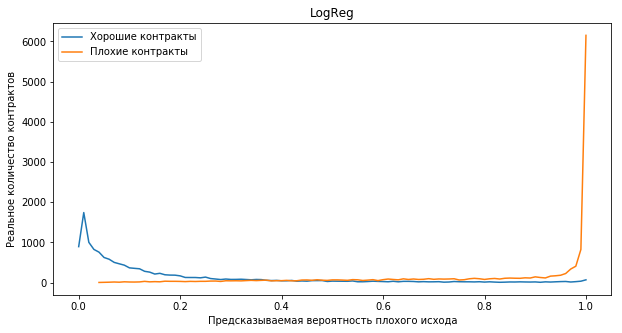

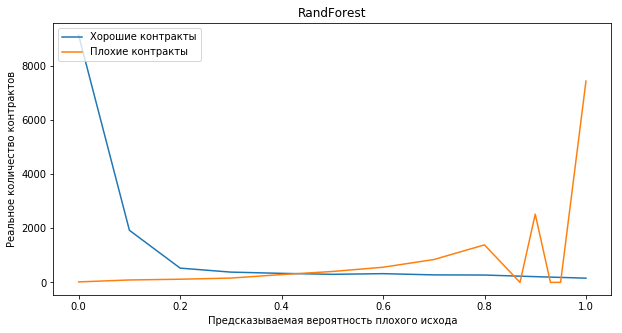

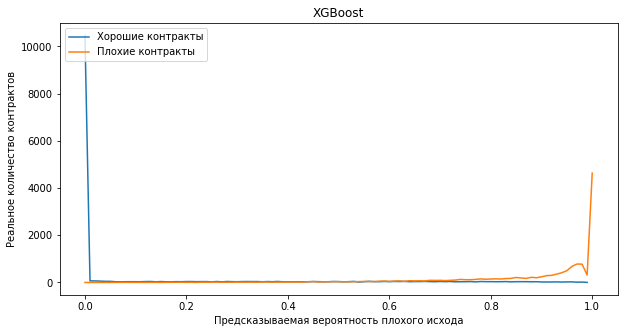

In [32]:
# Вероятностное предсказательное качество модели
# Распределение контрактов по предсказываемой вероятности отнесения наблюдения к плохому классу
for clf in classifiers:
    plot_dependence(clf.res, title=clf.short_name)

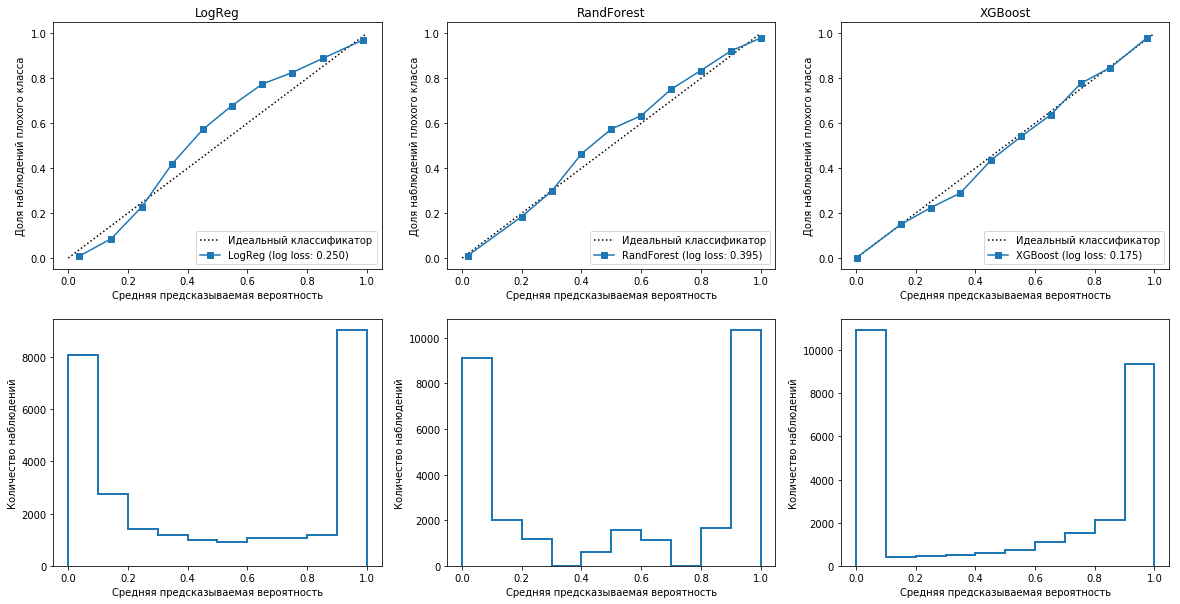

In [33]:
# Альтернативный способ визуализации вероятностного предсказательного качества классификаторов
assess_probability_power(classifiers)

### Валидация модели

In [34]:
cdfv = df_valid.copy()
# df_valid = cdfv.copy()

In [35]:
df_valid = df_valid[var + ['cntr_result']]

In [36]:
df_valid = process_numerical(df_valid, train=False)
df_valid = process_nominal(df_valid, train=False)

unused = df_train.loc[~df_train.cntrID.isin(good_cntr.cntrID) & (df_train.cntr_result==0)]
unused = unused[var + ['cntr_result']]
df_valid = df_valid.append(unused)

print(df_valid.shape)
df_valid.head()

(26305, 22)


,cntrID,sup_cntr_num,sup_running_cntr_num,sup_cntr_avg_price,org_cntr_num,org_cntr_avg_price,org_running_cntr_num,cntr_length,one_day_price,sup_good_cntr_share,sup_fed_cntr_share,sup_sub_cntr_share,sup_mun_cntr_share,sup_sim_price_share,org_good_cntr_share,org_sim_price_share,okpd_good_cntr_share,org_type,okpd2,purch_type,quarter,cntr_result
0,32352291,-0.171009,0.034898,-0.484685,1.305286,1.106514,0.345025,0.843806,-0.565641,1.000000,0.666667,0.333333,0.000000,0.333,0.990060,0.100,1.011099,0.02,-1.086,-0.088,-0.166,0.0
1,34748597,-1.205234,-0.693879,-0.170922,0.037029,0.524763,0.364288,0.271696,-0.178119,1.000000,1.000000,0.000000,0.000000,1.000,0.985011,0.113,1.010274,0.02,-1.887,-0.088,-0.277,0.0
2,32503663,1.900106,2.681034,-1.204586,0.159925,-1.627791,-0.254055,-0.143429,-0.556638,0.986175,0.211982,0.788018,0.000000,0.088,0.968401,0.102,1.036036,-0.36,-0.562,-0.088,-0.277,0.0
3,40043960,-0.571102,-0.693879,-0.391957,0.787259,2.964051,0.137723,-0.306130,0.427032,1.000000,0.666667,0.000000,0.333333,0.333,0.993682,0.103,1.079040,0.242,1.014,-0.088,0.488,0.0
4,33698468,-0.571102,-0.693879,-0.421676,-0.213396,-0.526700,0.430649,-0.362243,-0.701470,0.666667,1.000000,0.000000,0.000000,0.333,0.740000,0.111,1.070969,0.242,1.69,-0.088,-0.029,1.0


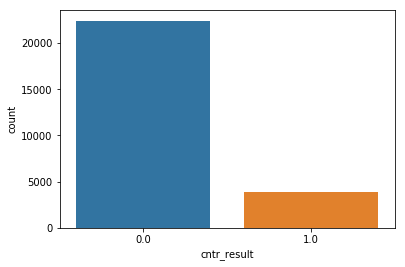

In [37]:
sbs.countplot(x='cntr_result', data=df_valid)

In [38]:
X_valid = df_valid.drop(['cntr_result', 'cntrID'], axis=1).values
y_valid = df_valid.cntr_result.values

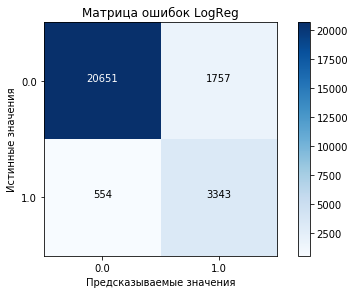

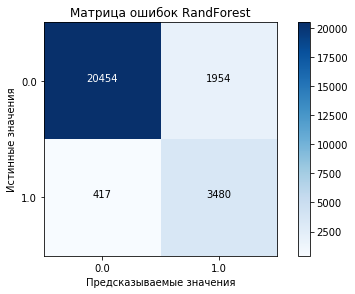

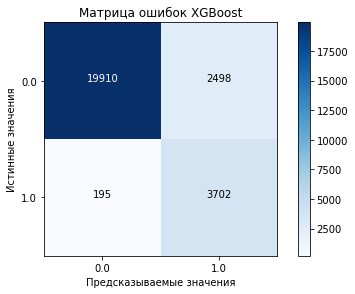

In [39]:
for clf in classifiers:
    plot_confusion_matrix(
        confusion_matrix(y_valid, clf.clf.predict(X_valid)),
        clf.clf.classes_,
        title='Матрица ошибок %s' % clf.short_name
    )

In [40]:
# Основные метрики
for clf in classifiers:
    print('{}\n{}\n'.format(
        clf.short_name,
        classification_report(y_valid, clf.clf.predict(X_valid))))

LogReg
             precision    recall  f1-score   support

        0.0       0.97      0.92      0.95     22408
        1.0       0.66      0.86      0.74      3897

avg / total       0.93      0.91      0.92     26305


RandForest
             precision    recall  f1-score   support

        0.0       0.98      0.91      0.95     22408
        1.0       0.64      0.89      0.75      3897

avg / total       0.93      0.91      0.92     26305


XGBoost
             precision    recall  f1-score   support

        0.0       0.99      0.89      0.94     22408
        1.0       0.60      0.95      0.73      3897

avg / total       0.93      0.90      0.91     26305




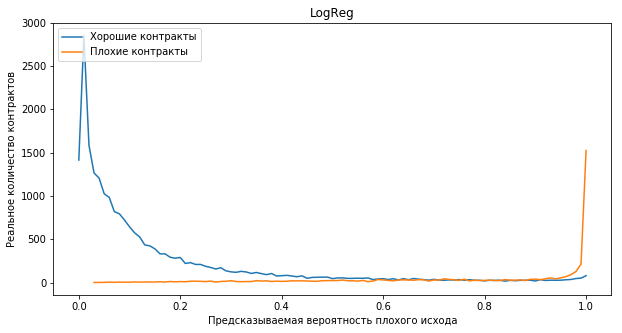

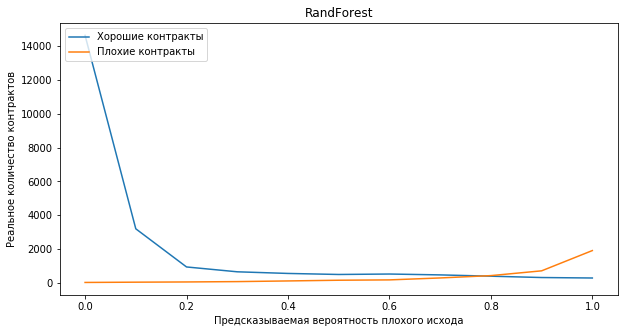

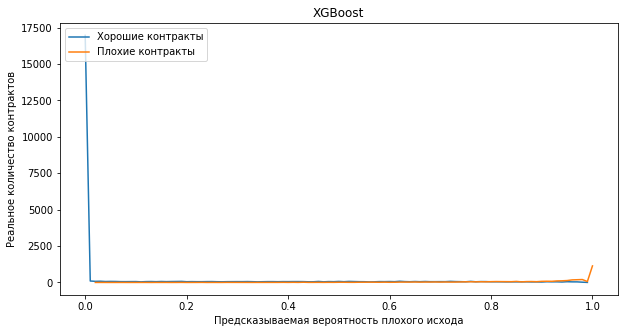

In [41]:
for clf in classifiers:
    plot_dependence(
        real_and_predicted_correlation(y_valid, clf.clf.predict(X_valid), clf.clf.predict_proba(X_valid)), 
        title=clf.short_name)

### Построение предсказаний

In [42]:
pd_copy = pred_data.copy()
# pred_data = pd_copy.copy()
print(pred_data.shape)
pred_data.head()

(62465, 47)


,valID,cntrID,supID,orgID,okpdID,sup_cntr_num,sup_running_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty_share,sup_no_pnl_share,sup_1s_sev,sup_1s_org_sev,sup_okpd_cntr_num,sup_sim_price_share,org_cntr_num,org_running_cntr_num,org_cntr_avg_price,org_1s_sev,org_1s_sup_sev,org_sim_price_share,cntr_num_together,org_type,okpd_cntr_num,okpd_good_cntr_num,price,pmp,cntr_lvl,sign_date,exec_date,purch_type,price_higher_pmp,price_too_low,cntr_result,okpd2,sup_good_cntr_share,sup_fed_cntr_share,sup_sub_cntr_share,sup_mun_cntr_share,sup_okpd_exp,org_good_cntr_share,org_fed_cntr_share,org_sub_cntr_share,org_mun_cntr_share,okpd_good_cntr_share,quarter,cntr_length,one_day_price
0,211634406,40294986,10471280,370815,151706,56,50,999193,0.0000,1.00000,0,0.0,5,0.054,1535,1601,1537428,0,0.0,0.121,9,16,82384.0,85499,943976,0,1,20170324,20171225,3,0,0,NaN,21,1.000000,0.160714,0.839286,0.000000,3.607143,0.985668,1.0,0.0,0.0,1.036036,1,276,3420
1,208406720,40203034,10215213,539568,151605,10,1,104405,0.0000,1.00000,0,0.0,4,0.000,135,55,157563,0,0.0,0.111,3,16,138989.0,143096,327236,0,1,20170410,20171231,3,0,0,NaN,20,1.000000,0.600000,0.400000,0.000000,1.200000,1.000000,1.0,0.0,0.0,1.030118,2,265,1234
2,207068009,41647139,10037445,535173,150589,333,241,854827,0.0000,1.00000,0,0.0,52,0.096,547,125,400659,0,0.0,0.033,6,30,13047.0,14003,986256,0,1,20170726,20171031,3,0,0,NaN,19,0.921922,0.630631,0.093093,0.276276,21.918919,0.978062,1.0,0.0,0.0,1.079040,3,97,10167
3,206512776,41127238,9887361,584149,147886,69,45,67281,0.0000,1.00000,0,0.0,4,0.058,104,18,457816,0,0.0,0.106,19,18,32778.0,37090,48952,0,1,20170613,20171231,3,0,0,NaN,10,0.956522,0.275362,0.695652,0.028986,2.115942,1.000000,1.0,0.0,0.0,1.108748,2,201,243
4,209379501,41665743,10760946,423078,151054,11,3,402402,0.0002,0.90909,0,0.0,2,0.091,1601,1724,6720028,0,0.0,0.079,8,16,95.0,96,111123,0,1,20170721,20171229,4,0,0,NaN,20,1.000000,1.000000,0.000000,0.000000,4.272727,0.879450,1.0,0.0,0.0,1.030118,3,161,690


In [43]:
pred_data.okpd_good_cntr_share = pred_data.okpd_good_cntr_num / pred_data.okpd_cntr_num
pred_data = pred_data.loc[(pred_data.sign_date >= 20170000) & (pred_data.exec_date >= 20180600)]
print(pred_data.shape)

(1138, 47)


In [44]:
pred_data = process_numerical(pred_data, train=False)
pred_data = process_nominal(pred_data, train=False)
pred_data = pred_data[var]
print(pred_data.shape)
pred_data.head()

(1138, 21)


,cntrID,sup_cntr_num,sup_running_cntr_num,sup_cntr_avg_price,org_cntr_num,org_cntr_avg_price,org_running_cntr_num,cntr_length,one_day_price,sup_good_cntr_share,sup_fed_cntr_share,sup_sub_cntr_share,sup_mun_cntr_share,sup_sim_price_share,org_good_cntr_share,org_sim_price_share,okpd_good_cntr_share,org_type,okpd2,purch_type,quarter
87,39661375,1.359117,2.114862,2.283780,0.616312,1.251358,1.948503,1.429967,1.095074,0.988235,0.317647,0.682353,0.000000,0.106,0.970330,0.018,1.123656,0.02,0.303,1.296,0.488
98,39054652,1.064262,1.223481,-0.201709,-0.179339,0.313003,0.389164,1.429967,-0.374784,0.960784,0.294118,0.705882,0.000000,0.098,0.939560,0.126,1.027443,0.02,-0.562,-0.088,0.488
193,40830829,1.464355,0.954511,-0.426622,0.689478,0.048453,1.285405,1.402383,-0.229997,0.901961,0.362745,0.607843,0.029412,0.049,0.742424,0.067,1.101573,0.02,0.277,-0.088,-0.166
207,41184479,1.694609,3.012484,1.029735,-0.461549,-0.745225,0.096977,1.429967,-0.231569,0.993421,0.118421,0.881579,0.000000,0.132,0.756654,0.095,1.029549,0.02,-1.436,-0.088,-0.166
249,41760857,0.275285,0.034898,-0.664270,-0.581755,0.815055,-0.083181,1.420860,0.399944,1.000000,0.076923,0.923077,0.000000,0.000,0.816594,0.109,1.088354,0.02,1.271,-0.088,-0.277


In [45]:
X_pred = pred_data.drop(['cntrID'], axis=1).values

for clf in classifiers:
    pred_data[clf.short_name[:6] + '_cls'] = clf.clf.predict(X_pred)
for clf in classifiers:
    pred_data[clf.short_name[:6] + '_proba'] = clf.clf.predict_proba(X_pred)[:,1]

In [46]:
not_old_train_cntr = list(df.loc[df.sign_date > 20170700].cntrID)
not_old_pred_cntr = list(pred_data.cntrID)
not_old_cntr = not_old_train_cntr + not_old_pred_cntr

print(len(not_old_train_cntr), len(not_old_pred_cntr))

1797 1138


In [47]:
final = sample.loc[sample.cntrID.isin(not_old_cntr)]

In [49]:
final['link'] = 0
final = final[[
    'valID', 'cntrID', 'supID', 'orgID', 'okpdID', 
    
    'cntr_reg_num', 'link', 'print_form', 'publish_date', 'sign_date', 'exec_date', 
    'grbs_code', 'grbs_name', 'org_name','sup_name', 'sup_INN', 'sup_KPP', 'kbk', 'purch', 
    
    'sup_cntr_num', 'sup_running_cntr_num', 'sup_cntr_avg_price',
    'sup_cntr_avg_penalty_share', 'sup_no_pnl_share', 'sup_1s_sev',
    'sup_1s_org_sev', 'sup_okpd_cntr_num', 'sup_sim_price_share', 'sup_good_cntr_share',
    'sup_fed_cntr_share', 'sup_sub_cntr_share', 'sup_mun_cntr_share', 'sup_okpd_exp', 
    
    'org_cntr_num', 'org_running_cntr_num', 'org_cntr_avg_price',
    'org_1s_sev', 'org_1s_sup_sev', 'org_sim_price_share', 'org_good_cntr_share',
    'org_fed_cntr_share','org_sub_cntr_share', 'org_mun_cntr_share',
    'cntr_num_together', 'org_type', 
    
    'okpd_cntr_num', 'okpd_good_cntr_num', 'price', 'pmp', 'purch_type',
    'price_higher_pmp', 'price_too_low', 'okpd2',  'okpd_good_cntr_share',
    'quarter', 'cntr_length', 'one_day_price', 'cntr_result']]    

In [50]:
f1 = final.merge(
    pred_data[['cntrID', 'LogReg_cls', 'RandFo_cls', 'XGBoos_cls', 'LogReg_proba', 'RandFo_proba', 'XGBoos_proba']],
    on='cntrID')
print(f1.shape)

(1138, 64)


In [51]:
train = final.loc[final.cntrID.isin(not_old_train_cntr)]
train = process_numerical(train, train=False)
train = process_nominal(train, train=False)
train = train[var]

X_train = train.drop(['cntrID'], axis=1).values

for clf in classifiers:
    train[clf.short_name[:6] + '_cls'] = clf.clf.predict(X_train)
for clf in classifiers:
    train[clf.short_name[:6] + '_proba'] = clf.clf.predict_proba(X_train)[:,1]

In [52]:
f2 = final.merge(
    train[['cntrID', 'LogReg_cls', 'RandFo_cls', 'XGBoos_cls', 'LogReg_proba', 'RandFo_proba', 'XGBoos_proba']],
    on='cntrID')
print(f2.shape)

(1797, 64)


In [53]:
ff = f1.append(f2)

In [54]:
ff = ff.drop(['cntrID', 'valID', 'orgID', 'supID', 'okpdID'], axis=1)

for var in ('cntr_reg_num', 'sup_INN', 'sup_KPP'):
    ff[var] = ff[var].astype(str)

ff.drop(['kbk'], inplace=True, axis=1)

link = 'http://zakupki.gov.ru/epz/contract/contractCard/common-info.html?reestrNumber='
ff['link'] = ff['cntr_reg_num'].apply(lambda a: pd.Series(link + str(a)))

In [55]:
ff.head()

,cntr_reg_num,link,print_form,publish_date,sign_date,exec_date,grbs_code,grbs_name,org_name,sup_name,sup_INN,sup_KPP,purch,sup_cntr_num,sup_running_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty_share,sup_no_pnl_share,sup_1s_sev,sup_1s_org_sev,sup_okpd_cntr_num,sup_sim_price_share,sup_good_cntr_share,sup_fed_cntr_share,sup_sub_cntr_share,sup_mun_cntr_share,sup_okpd_exp,org_cntr_num,org_running_cntr_num,org_cntr_avg_price,org_1s_sev,org_1s_sup_sev,org_sim_price_share,org_good_cntr_share,org_fed_cntr_share,org_sub_cntr_share,org_mun_cntr_share,cntr_num_together,org_type,okpd_cntr_num,okpd_good_cntr_num,price,pmp,purch_type,price_higher_pmp,price_too_low,okpd2,okpd_good_cntr_share,quarter,cntr_length,one_day_price,cntr_result,LogReg_cls,RandFo_cls,XGBoos_cls,LogReg_proba,RandFo_proba,XGBoos_proba
0,1781025163017000012,http://zakupki.gov.ru/epz/contract/contractCar...,http://zakupki.gov.ru/epz/contract/printForm/v...,20170216,20170214,20180630,NaN,NaN,ФГБОУ ВО СПБГУ ГА,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЕВРО...",7804345713,780401001,Конкурс с ограниченным участием,85,69,7787090,0.0,1.0,0,0.0,4,0.106,0.988235,0.317647,0.682353,0.000000,14.011765,910,3115,2312772,0,0.0,0.018,0.970330,1.0,0.0,0.0,2,16,372.0,418,9347840,0,11,0,0,01,1.139258,1,501,18658,NaN,0.0,0.0,0.0,0.335775,0.4,0.347304
1,1519005315917000014,http://zakupki.gov.ru/epz/contract/contractCar...,http://zakupki.gov.ru/epz/contract/printForm/v...,20170117,20170117,20180630,NaN,NaN,ФГБУЗ ММЦ ИМ. Н.И. ПИРОГОВА ФМБА РОССИИ,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""РЕГИ...",7802842205,780201001,Электронный аукцион,51,18,244869,0.0,1.0,0,0.0,3,0.098,0.960784,0.294118,0.705882,0.000000,0.235294,364,226,912534,0,0.0,0.126,0.939560,1.0,0.0,0.0,4,16,43509.0,44703,741464,0,3,0,0,21,1.036036,1,529,1401,NaN,0.0,1.0,1.0,0.254676,0.7,0.522594
2,1720401364217000127,http://zakupki.gov.ru/epz/contract/contractCar...,http://zakupki.gov.ru/epz/contract/printForm/v...,20170515,20170511,20180630,NaN,NaN,"ФБУ ЦЕНТР РЕАБИЛИТАЦИИ ""ТАРАСКУЛЬ""",Фраас Екатерина Викторовна,741109827469,0,Электронный аукцион,102,12,179051,0.0,1.0,0,0.0,1,0.049,0.901961,0.362745,0.607843,0.029412,0.950980,990,828,702073,0,0.0,0.067,0.742424,1.0,0.0,0.0,19,16,10170.0,11203,750714,0,3,0,0,10,1.108748,2,415,1808,NaN,1.0,1.0,1.0,0.694025,0.9,0.758201
3,1253900811617000527,http://zakupki.gov.ru/epz/contract/contractCar...,http://zakupki.gov.ru/epz/contract/printForm/v...,20170620,20170614,20181030,NaN,NaN,Восточная больница ФГБУЗ ДВОМЦ ФМБА России,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ПАСИ...",2536075410,253601001,Электронный аукцион,152,267,1359326,0.0,1.0,0,0.0,16,0.132,0.993421,0.118421,0.881579,0.000000,3.539474,263,148,319720,0,0.0,0.095,0.756654,1.0,0.0,0.0,2,16,138989.0,143096,907074,0,3,0,0,20,1.030118,2,503,1803,NaN,0.0,0.0,0.0,0.078423,0.1,0.136839
4,1781204352217000021,http://zakupki.gov.ru/epz/contract/contractCar...,http://zakupki.gov.ru/epz/contract/printForm/v...,20170804,20170803,20180930,NaN,NaN,"СПБГМТУ, ФГБОУ ВО ""САНКТ-ПЕТЕРБУРГСКИЙ ГОСУДАР...","Общество с ограниченной ответственностью ""Вект...",7804488670,780401001,Электронный аукцион,13,3,128624,0.0,1.0,0,0.0,8,0.000,1.000000,0.076923,0.923077,0.000000,0.615385,229,114,1500862,0,0.0,0.109,0.816594,1.0,0.0,0.0,1,16,8398.0,9140,2320000,0,3,0,0,43,1.049705,3,423,5484,NaN,0.0,0.0,0.0,0.321540,0.2,0.000861


In [56]:
# Экспорт предсказаний в Excel
writer = pd.ExcelWriter('../../predictions.xlsx')
ff.to_excel(writer,'Sheet1', encoding='cp1251')
writer.save()